In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## Constructing feature dataframes

In [52]:
metadata = 'E:/User/bruna.fistarol/HMM/Salmonella/metadata.tab'

In [53]:
df = pd.read_csv(metadata, sep='\t', header=None, names=['Strain', 'Antibiotic', 'MIC'])

In [54]:
df

Strain Antibiotic  MIC
0      SRR1177335    AMP:MIC    1
1      SRR1177335    AUG:MIC    1
2      SRR1177335    AXO:MIC    1
3      SRR1177335    CHL:MIC    1
4      SRR1177335    FOX:MIC    1
...           ...        ...  ...
19340  SRR4280647    FOX:MIC    1
19341  SRR4280647    GEN:MIC    1
19342  SRR4280647    STR:MIC    4
19343  SRR4280647    TET:MIC    4
19344  SRR4280647    TIO:MIC    1

[19345 rows x 3 columns]

In [55]:
pivot_df = df.pivot_table(index='Strain', columns='Antibiotic', values='MIC', aggfunc='first')

In [56]:
pivot_df.columns = pivot_df.columns.str.rstrip(':MIC')

In [57]:
pivot_df

Antibiotic  AMP  AUG  AXO  CHL  FIS  FOX  GEN  KAN  STR  TET  TIO
Strain                                                           
SRR1177335  1.0  1.0  1.0  1.0  NaN  1.0  4.0  NaN  4.0  4.0  1.0
SRR1177356  1.0  1.0  1.0  1.0  NaN  1.0  1.0  NaN  NaN  4.0  1.0
SRR1177360  1.0  1.0  1.0  1.0  NaN  1.0  1.0  NaN  NaN  1.0  1.0
SRR1177369  1.0  1.0  1.0  1.0  NaN  1.0  1.0  NaN  4.0  4.0  1.0
SRR1181521  1.0  1.0  1.0  1.0  NaN  1.0  1.0  NaN  4.0  4.0  1.0
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
SRR4280629  1.0  1.0  1.0  1.0  1.0  1.0  4.0  NaN  4.0  1.0  1.0
SRR4280640  1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  4.0  4.0  1.0
SRR4280641  1.0  1.0  1.0  1.0  4.0  1.0  1.0  NaN  1.0  4.0  1.0
SRR4280642  4.0  4.0  4.0  1.0  4.0  4.0  1.0  NaN  1.0  4.0  4.0
SRR4280647  4.0  2.0  1.0  4.0  4.0  1.0  1.0  NaN  4.0  4.0  1.0

[1999 rows x 11 columns]

### Creating a table for each antibiotic

In [83]:
# A dictionary to store individual dataframes
dfs = {}

# Split each column into a new dataframe
for col in pivot_df.columns:
    dfs[col] = pivot_df[[col]].dropna()

### Add e-values for each susceptibility profile

In [84]:
hmm_search_path = 'E:/User/bruna.fistarol/HMM/Salmonella/Pfam_hmm_search'

In [85]:
for pfam in os.listdir(hmm_search_path):
    
    search_file = pd.read_csv(hmm_search_path + '/' + pfam, sep = '\t', comment = '#', header=None)
    s = search_file[0].str.split()
    evalues = pd.DataFrame(s.tolist())
    evalues.columns = ['target_name', 'accession', 'query_name', 'accession', 'E-value_fullseq', 'score_fullseq', 'bias_fullseq', 'E-value_bestdomain', 'score_bestdomain', 'bias_bestdomain', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description_of_target']
    evalues['target_name'] = evalues['target_name'].str.rstrip('.fasta')
    #evalues = evalues[['target_name', 'E-value_fullseq']].set_index('target_name', drop = True)
    evalues = evalues[['target_name', 'score_fullseq']].set_index('target_name', drop = True)
    #evalues.rename(columns={'E-value_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)
    evalues.rename(columns={'score_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)
    
    for antibiotic, table in dfs.items():
        dfs[antibiotic] = pd.concat([table, evalues], axis=1)


We need to drop rows with NaN:

In [86]:
for antibiotic in dfs.keys():
    dfs[antibiotic].dropna(inplace = True)

In [12]:
dfs['AMP']

AMP PLF_590_00000030 PLF_590_00000052 PLF_590_00000054  \
SRR1177335  1.0           2224.2            535.5           1103.1   
SRR1177356  1.0           2239.5            534.2           1109.1   
SRR1181521  1.0           2241.7            534.2           1109.1   
SRR1181532  1.0           2241.7            535.5           1109.1   
SRR1181559  1.0           2239.9            534.2           1109.1   
...         ...              ...              ...              ...   
SRR4280624  1.0           2238.4            535.5           1105.7   
SRR4280640  1.0           2232.6            533.7           1097.9   
SRR4280641  1.0           2242.3            534.2           1109.1   
SRR4280642  4.0           2242.3            534.2           1109.1   
SRR4280647  4.0           1808.5            534.2           1109.1   

           PLF_590_00000074 PLF_590_00000084 PLF_590_00000090  \
SRR1177335           3071.9           6620.8           1410.8   
SRR1177356           3095.7           6661.0           1427.5   
SRR1181521           3095.3           6662.2           1437.3   
SRR1181532           3093.9           6663.0           1434.1   
SRR1181559           1314.0           6665.3           1437.3   
...                     ...              ...              ...   
SRR4280624           3090.8           6649.1           1442.0   
SRR4280640           3072.5           6622.0           1422.1   
SRR4280641           3095.7           6663.1           1431.9   
SRR4280642           3095.7           6665.8           1431.9   
SRR4280647           3095.7           6665.8           1431.9   

           PLF_590_00000091 PLF_590_00000093 PLF_590_00000103  ...  \
SRR1177335           1884.5           5326.0           4750.8  ...   
SRR1177356           1902.5           5328.4           4810.2  ...   
SRR1181521            147.1           5349.6           4806.0  ...   
SRR1181532           1898.0           5329.9           4810.2  ...   
SRR1181559            147.1           5349.6           4806.0  ...   
...                     ...              ...              ...  ...   
SRR4280624           1889.5           5330.4           4783.7  ...   
SRR4280640           1885.1           5322.5           4752.4  ...   
SRR4280641           1902.5           5328.4           4810.2  ...   
SRR4280642           1902.5           5328.4           4807.8  ...   
SRR4280647           1902.5           5328.4           4810.2  ...   

           PLF_590_00003850 PLF_590_00003867 PLF_590_00004055  \
SRR1177335            431.1            923.6            797.8   
SRR1177356            431.1            928.0            801.7   
SRR1181521            431.1            928.0            801.7   
SRR1181532            429.9            920.8            801.7   
SRR1181559            431.1            928.0            801.7   
...                     ...              ...              ...   
SRR4280624            429.9            918.3            801.2   
SRR4280640            431.1            915.8            796.2   
SRR4280641            431.1            928.0            800.5   
SRR4280642            431.1            928.0            800.5   
SRR4280647            431.1            928.0            801.7   

           PLF_590_00004695 PLF_590_00004860 PLF_590_00006292  \
SRR1177335            416.5            329.2          15349.8   
SRR1177356            417.0            343.4          15473.2   
SRR1181521            417.5            340.7          15459.2   
SRR1181532            417.5            343.4          15448.3   
SRR1181559            417.5            340.7          15459.2   
...                     ...              ...              ...   
SRR4280624            417.5            341.4          15399.3   
SRR4280640            416.5            329.2          15358.6   
SRR4280641            417.0            343.4          15480.5   
SRR4280642            417.0            343.4          15480.5   
SRR4280647            417.0            343.4         

### Treating the e-values and replacing MIC for a binary classification

In [65]:
def sigmoid(x):
    return(1/ (1 + np.exp(-x)))

def siglog(x):
    return sigmoid(-np.log(x))

def profile(x):
    if x <= 2:
        return(0)
    else:
        return(1)

In [92]:
for antibiotic in dfs_2.keys():
    dfs_2[antibiotic] = dfs_2[antibiotic].astype('float')
    #dfs[antibiotic].iloc[:, 1:] = dfs[antibiotic].iloc[:, 1:].apply(np.log)
    #dfs[antibiotic].iloc[:, 0] = dfs[antibiotic].iloc[:, 0].apply(profile)

# Constructing DFs for scores from HMM per profile

In [36]:
# A dictionary to store individual dataframes
dfs_s = {}
dfs_r = {}

In [31]:
antibiotics_path = 'E:/User/bruna.fistarol/HMM/Salmonella/Antibiotics'

In [42]:
for col in pivot_df.columns:
    dfs_s[col] = pd.DataFrame()
    dfs_r[col] = pd.DataFrame()

In [43]:
for a in os.listdir(antibiotics_path):

    hmm_search_path = os.path.join(antibiotics_path, a, 'Susceptible', 'Pfam_hmm_search')

    for pfam in os.listdir(hmm_search_path):

        search_file = pd.read_csv(hmm_search_path + '/' + pfam, sep = '\t', comment = '#', header=None)
        s = search_file[0].str.split()
        evalues = pd.DataFrame(s.tolist())
        evalues.columns = ['target_name', 'accession', 'query_name', 'accession', 'E-value_fullseq', 'score_fullseq', 'bias_fullseq', 'E-value_bestdomain', 'score_bestdomain', 'bias_bestdomain', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description_of_target']
        evalues['target_name'] = evalues['target_name'].str.rstrip('.fasta')
        #evalues = evalues[['target_name', 'E-value_fullseq']].set_index('target_name', drop = True)
        evalues = evalues[['target_name', 'score_fullseq']].set_index('target_name', drop = True)
        #evalues.rename(columns={'E-value_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)
        evalues.rename(columns={'score_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)

        dfs_s[a] = pd.concat([dfs_s[a], evalues], axis=1)
    
    dfs_s[a].insert(loc = 0, column = a, value = 0)
        
        
    hmm_search_path = os.path.join(antibiotics_path, a, 'Resistant', 'Pfam_hmm_search')

    for pfam in os.listdir(hmm_search_path):

        search_file = pd.read_csv(hmm_search_path + '/' + pfam, sep = '\t', comment = '#', header=None)
        s = search_file[0].str.split()
        evalues = pd.DataFrame(s.tolist())
        evalues.columns = ['target_name', 'accession', 'query_name', 'accession', 'E-value_fullseq', 'score_fullseq', 'bias_fullseq', 'E-value_bestdomain', 'score_bestdomain', 'bias_bestdomain', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description_of_target']
        evalues['target_name'] = evalues['target_name'].str.rstrip('.fasta')
        #evalues = evalues[['target_name', 'E-value_fullseq']].set_index('target_name', drop = True)
        evalues = evalues[['target_name', 'score_fullseq']].set_index('target_name', drop = True)
        #evalues.rename(columns={'E-value_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)
        evalues.rename(columns={'score_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)

        dfs_r[a] = pd.concat([dfs_r[a], evalues], axis=1)
        
    dfs_r[a].insert(loc = 0, column = a, value = 1)


In [74]:
dfs_2 = {}
for a in os.listdir(antibiotics_path):
    dfs_2[a] = pd.concat([dfs_s[a].sort_index(), dfs_r[a].sort_index()], axis=0)


In [81]:
for a in os.listdir(antibiotics_path):
    dfs[a] = pd.concat([dfs[a][dfs[a][a] == 0].sort_index(), dfs[a][dfs[a][a] == 1].sort_index()], axis=0)

In [93]:
difference = dfs_2['AMP'] - dfs['AMP']

In [100]:
difference

AMP  PLF_590_00000030  PLF_590_00000052  PLF_590_00000054  \
SRR1177335  0.0               5.6              -0.1               0.7   
SRR1177356  0.0              -0.6              -0.6              -1.7   
SRR1181521  0.0              -2.2              -0.6              -1.7   
SRR1181532  0.0              -2.2              -0.1              -1.7   
SRR1181559  0.0              -2.2              -0.6              -1.7   
...         ...               ...               ...               ...   
SRR4280624  0.0               2.2              -0.1              -1.1   
SRR4280640  0.0               5.0               0.3               1.4   
SRR4280641  0.0              -0.6              -0.6              -1.7   
SRR4280642  0.0               5.2               0.2               1.5   
SRR4280647  0.0               9.2               0.2               1.5   

            PLF_590_00000074  PLF_590_00000084  PLF_590_00000090  \
SRR1177335               3.2              10.6              15.8   
SRR1177356              -3.5              -5.0             -12.6   
SRR1181521              -5.2              -0.9             -13.0   
SRR1181532              -5.6              -6.2             -13.2   
SRR1181559              -1.1              -0.9             -13.0   
...                      ...               ...               ...   
SRR4280624              -2.2               4.7              10.1   
SRR4280640               4.3              12.0              14.7   
SRR4280641              -3.5              -5.3             -12.7   
SRR4280642               5.6              15.8              32.2   
SRR4280647               5.6              15.8              32.2   

            PLF_590_00000091  PLF_590_00000093  PLF_590_00000103  ...  \
SRR1177335               5.0               0.1              11.7  ...   
SRR1177356              -0.1             -11.5              -7.6  ...   
SRR1181521              -2.1              -9.9              -0.8  ...   
SRR1181532               0.3             -12.2              -7.6  ...   
SRR1181559              -2.1              -9.9              -0.8  ...   
...                      ...               ...               ...  ...   
SRR4280624               2.4              -4.3               2.0  ...   
SRR4280640               5.5               0.7              12.3  ...   
SRR4280641              -0.1             -11.5              -7.6  ...   
SRR4280642               5.2               7.5               4.0  ...   
SRR4280647               5.2               7.5               3.9  ...   

            PLF_590_00003850  PLF_590_00003867  PLF_590_00004055  \
SRR1177335               0.9               1.5               0.7   
SRR1177356               0.9              -0.3              -0.3   
SRR1181521               0.9              -0.3              -0.3   
SRR1181532               0.5              -1.5              -0.3   
SRR1181559               0.9              -0.3              -0.3   
...                      ...               ...               ...   
SRR4280624               0.5               1.1               0.6   
SRR4280640               0.9               2.4               0.6   
SRR4280641               0.9              -0.3              -0.6   
SRR4280642               0.6               2.7               1.3   
SRR4280647               0.6               2.7               0.7   

            PLF_590_00004695  PLF_590_00004860  PLF_590_00006292  \
SRR1177335               0.4               3.2              39.1   
SRR1177356               0.3              -1.3             -15.9   
SRR1181521               0.4              -1.0              -4.5   
SRR1181532               0.4              -1.3              -8.0   
SRR1181559               0.4              -1.0              -4.5   
...                      ...               ...               ...   
SRR4280624               0.4              -1.4              10.2   
SRR4280640               0.4               3.2              40.9   
SRR4280641  

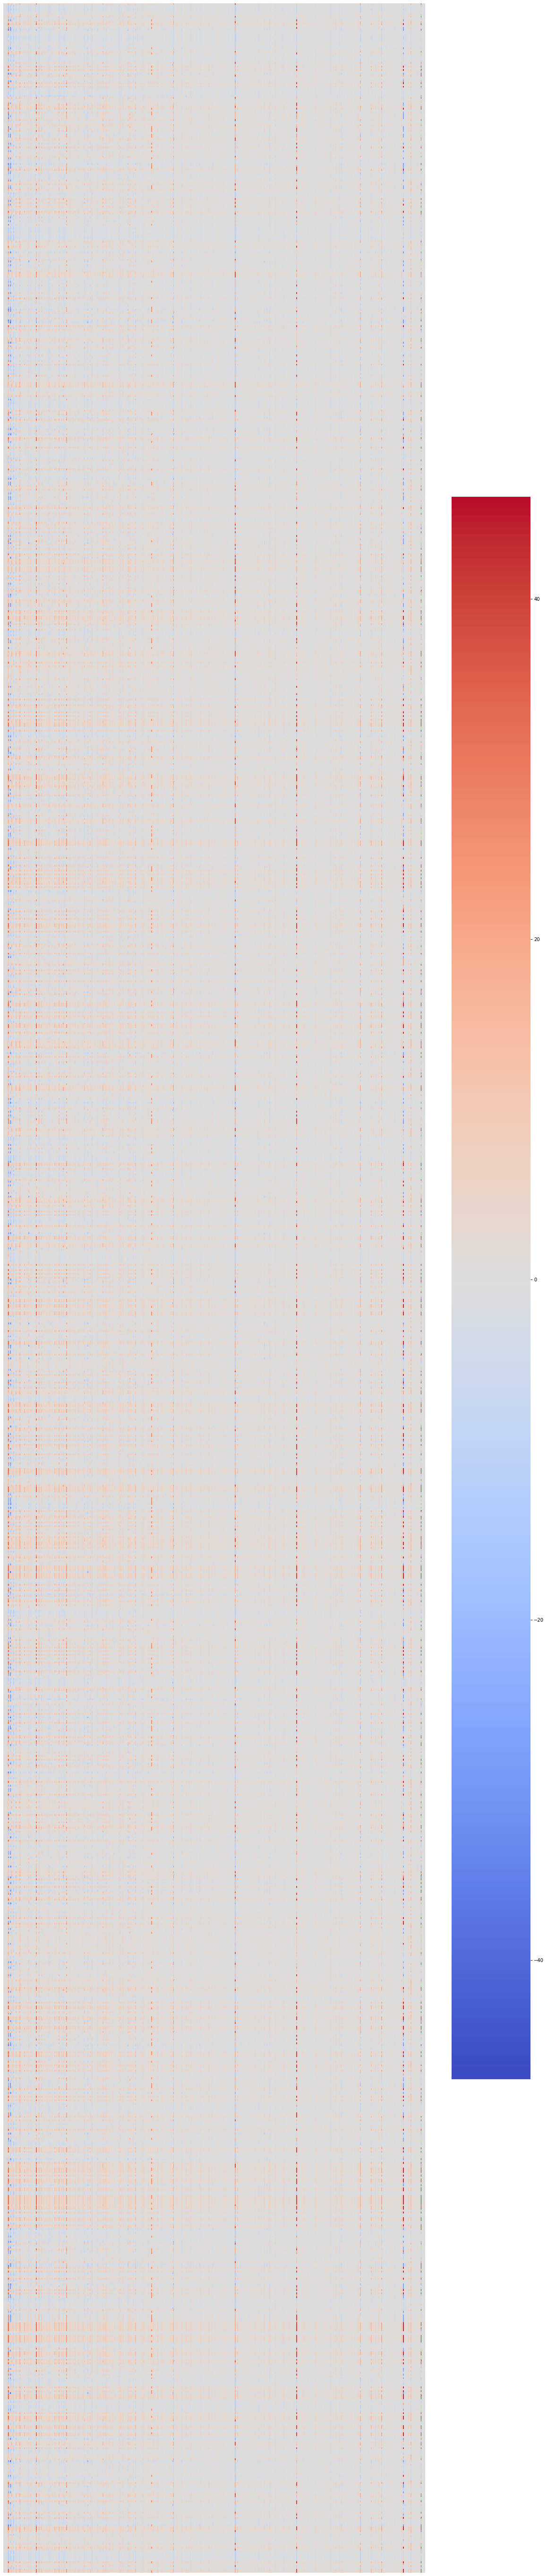

In [101]:
fig, ax = plt.subplots(figsize=(20, 100))  # Adjust as needed

# Create the heatmap
sns.heatmap(difference, cmap='coolwarm', center=0, cbar=True, ax=ax,
            xticklabels=False, yticklabels=False, annot=False, linewidths=0, linecolor='white')

# Remove the grid lines to make it easier to read
ax.grid(False)

plt.show()

In [102]:
# A dictionary to store individual dataframes
dfs_s_all = {}
dfs_r_all = {}

In [103]:
for col in pivot_df.columns:
    dfs_s_all[col] = pd.DataFrame()
    dfs_r_all[col] = pd.DataFrame()

In [ ]:
for a in os.listdir(antibiotics_path):

    hmm_search_path = os.path.join(antibiotics_path, a, 'Susceptible', 'Pfam_hmm_search_all')

    for pfam in os.listdir(hmm_search_path):

        search_file = pd.read_csv(hmm_search_path + '/' + pfam, sep = '\t', comment = '#', header=None)
        s = search_file[0].str.split()
        evalues = pd.DataFrame(s.tolist())
        evalues.columns = ['target_name', 'accession', 'query_name', 'accession', 'E-value_fullseq', 'score_fullseq', 'bias_fullseq', 'E-value_bestdomain', 'score_bestdomain', 'bias_bestdomain', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description_of_target']
        evalues['target_name'] = evalues['target_name'].str.rstrip('.fasta')
        #evalues = evalues[['target_name', 'E-value_fullseq']].set_index('target_name', drop = True)
        evalues = evalues[['target_name', 'score_fullseq']].set_index('target_name', drop = True)
        #evalues.rename(columns={'E-value_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)
        evalues.rename(columns={'score_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)

        dfs_s_all[a] = pd.concat([dfs_s_all[a], evalues], axis=1)
    
    dfs_s_all[a].insert(loc = 0, column = a, value = 0)
        
        
    hmm_search_path = os.path.join(antibiotics_path, a, 'Resistant', 'Pfam_hmm_search_all')

    for pfam in os.listdir(hmm_search_path):

        search_file = pd.read_csv(hmm_search_path + '/' + pfam, sep = '\t', comment = '#', header=None)
        s = search_file[0].str.split()
        evalues = pd.DataFrame(s.tolist())
        evalues.columns = ['target_name', 'accession', 'query_name', 'accession', 'E-value_fullseq', 'score_fullseq', 'bias_fullseq', 'E-value_bestdomain', 'score_bestdomain', 'bias_bestdomain', 'exp', 'reg', 'clu', 'ov', 'env', 'dom', 'rep', 'inc', 'description_of_target']
        evalues['target_name'] = evalues['target_name'].str.rstrip('.fasta')
        #evalues = evalues[['target_name', 'E-value_fullseq']].set_index('target_name', drop = True)
        evalues = evalues[['target_name', 'score_fullseq']].set_index('target_name', drop = True)
        #evalues.rename(columns={'E-value_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)
        evalues.rename(columns={'score_fullseq': f'{pfam}'.split('.')[0]}, inplace = True)

        dfs_r_all[a] = pd.concat([dfs_r_all[a], evalues], axis=1)
        
    dfs_r_all[a].insert(loc = 0, column = a, value = 1)


In [ ]:
dfs_hmm_0 = {}
for a in os.listdir(antibiotics_path):
    dfs_hmm_0[a] = pd.concat([dfs_s[a].sort_index(), dfs_r_all[a].sort_index()], axis=0)

dfs_hmm_1 = {}
for a in os.listdir(antibiotics_path):
    dfs_hmm_1[a] = pd.concat([dfs_s_all[a].sort_index(), dfs_r[a].sort_index()], axis=0)


In [ ]:
for antibiotic in dfs_2.keys():
    dfs_hmm_0[antibiotic] = dfs_hmm_0[antibiotic].astype('float')
    dfs_hmm_1[antibiotic] = dfs_hmm_1[antibiotic].astype('float')

In [ ]:
dfs_ratio = {}
for a in os.listdir(antibiotics_path):
    dfs_ratio[a] = pd.concat([dfs_hmm_0[a][a], dfs_hmm_0[a].loc[:, dfs_hmm_0.columns != a]/dfs_hmm_1[a].loc[:, dfs_hmm_1.columns != a]], axis=1)

# Visualizing 

In [155]:
antibiotics = list(dfs.keys())

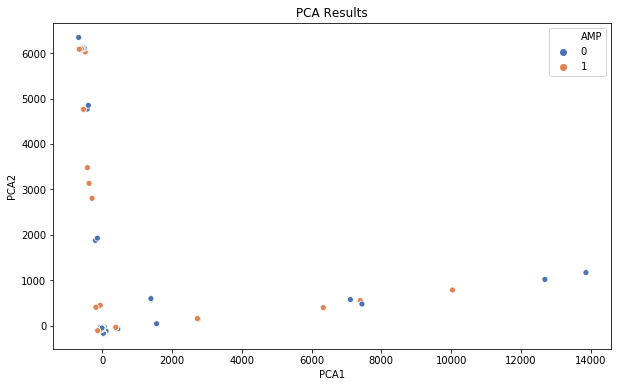

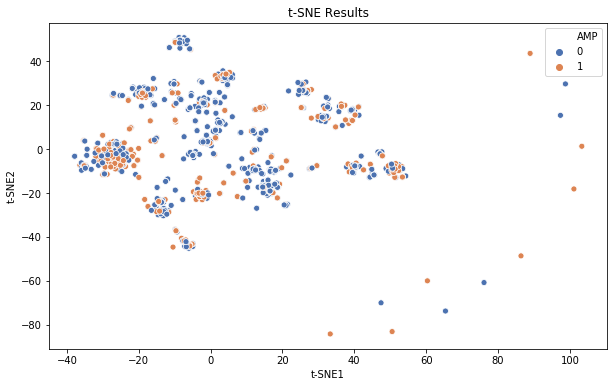

In [126]:
df = dfs['AMP']

# Separate out the features and labels
features = df.drop(columns=['AMP'])
labels = df['AMP']

# Apply PCA and reduce to two dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
df['PCA1'] = pca_result[:,0]
df['PCA2'] = pca_result[:,1]

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=labels, data=df, palette='deep')
plt.title('PCA Results')
plt.show()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)
df['t-SNE1'] = tsne_results[:,0]
df['t-SNE2'] = tsne_results[:,1]

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue=labels, data=df, palette='deep')
plt.title('t-SNE Results')
plt.show()

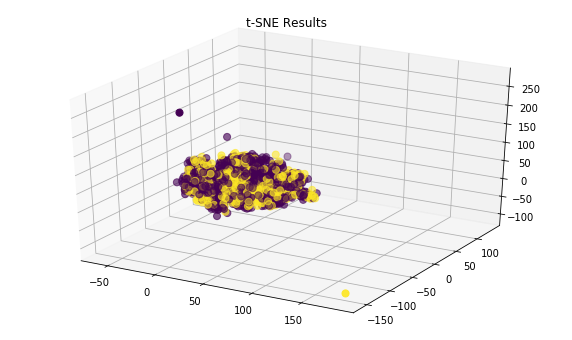

In [127]:
# Apply PCA and reduce to three dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)
df['PCA1'] = pca_result[:,0]
df['PCA2'] = pca_result[:,1]
df['PCA3'] = pca_result[:,2]

# Apply t-SNE with three dimensions
tsne = TSNE(n_components=3, random_state=10)
tsne_results = tsne.fit_transform(features)
df['t-SNE1'] = tsne_results[:,0]
df['t-SNE2'] = tsne_results[:,1]
df['t-SNE3'] = tsne_results[:,2]

# 3D Plot for t-SNE results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['t-SNE1'], df['t-SNE2'], df['t-SNE3'], c=labels, cmap='viridis', s=50)
ax.set_title('t-SNE Results')
plt.show()

In [128]:
def read_fasta_file(file_path):
    sequences = {}
    with open(file_path, 'r') as file:
        sequence = ''
        header = ''
        for line in file:
            if line.startswith('>'):
                if sequence and header:
                    sequences[header] = sequence
                    sequence = ''
                header = line.strip()[1:]
            else:
                sequence += line.strip()
        if sequence and header:
            sequences[header] = sequence
    return sequences

In [133]:
length_0 = ['PLF_590_00003204', 'PLF_590_00000441', 'PLF_590_00002421', 'PLF_590_00002841', 'PLF_590_00000215', 'PLF_590_00002480', 'PLF_590_00000236', 'PLF_590_00000543', 'PLF_590_00024086']

In [134]:
length_1 = list(read_fasta_file('E:/User/bruna.fistarol/HMM/Salmonella/length_1_mateosppi.fasta').keys())
length_2 = list(read_fasta_file('E:/User/bruna.fistarol/HMM/Salmonella/length_2_mateosppi.fasta').keys())
length_3 = list(read_fasta_file('E:/User/bruna.fistarol/HMM/Salmonella/length_3_mateosppi.fasta').keys())
length_4 = list(read_fasta_file('E:/User/bruna.fistarol/HMM/Salmonella/length_4_mateosppi.fasta').keys())

In [148]:
for a in antibiotics:
    print(len(dfs[a].index))

1396
1396
1396
1396
1306
1396
1396
235
799
1396
1396


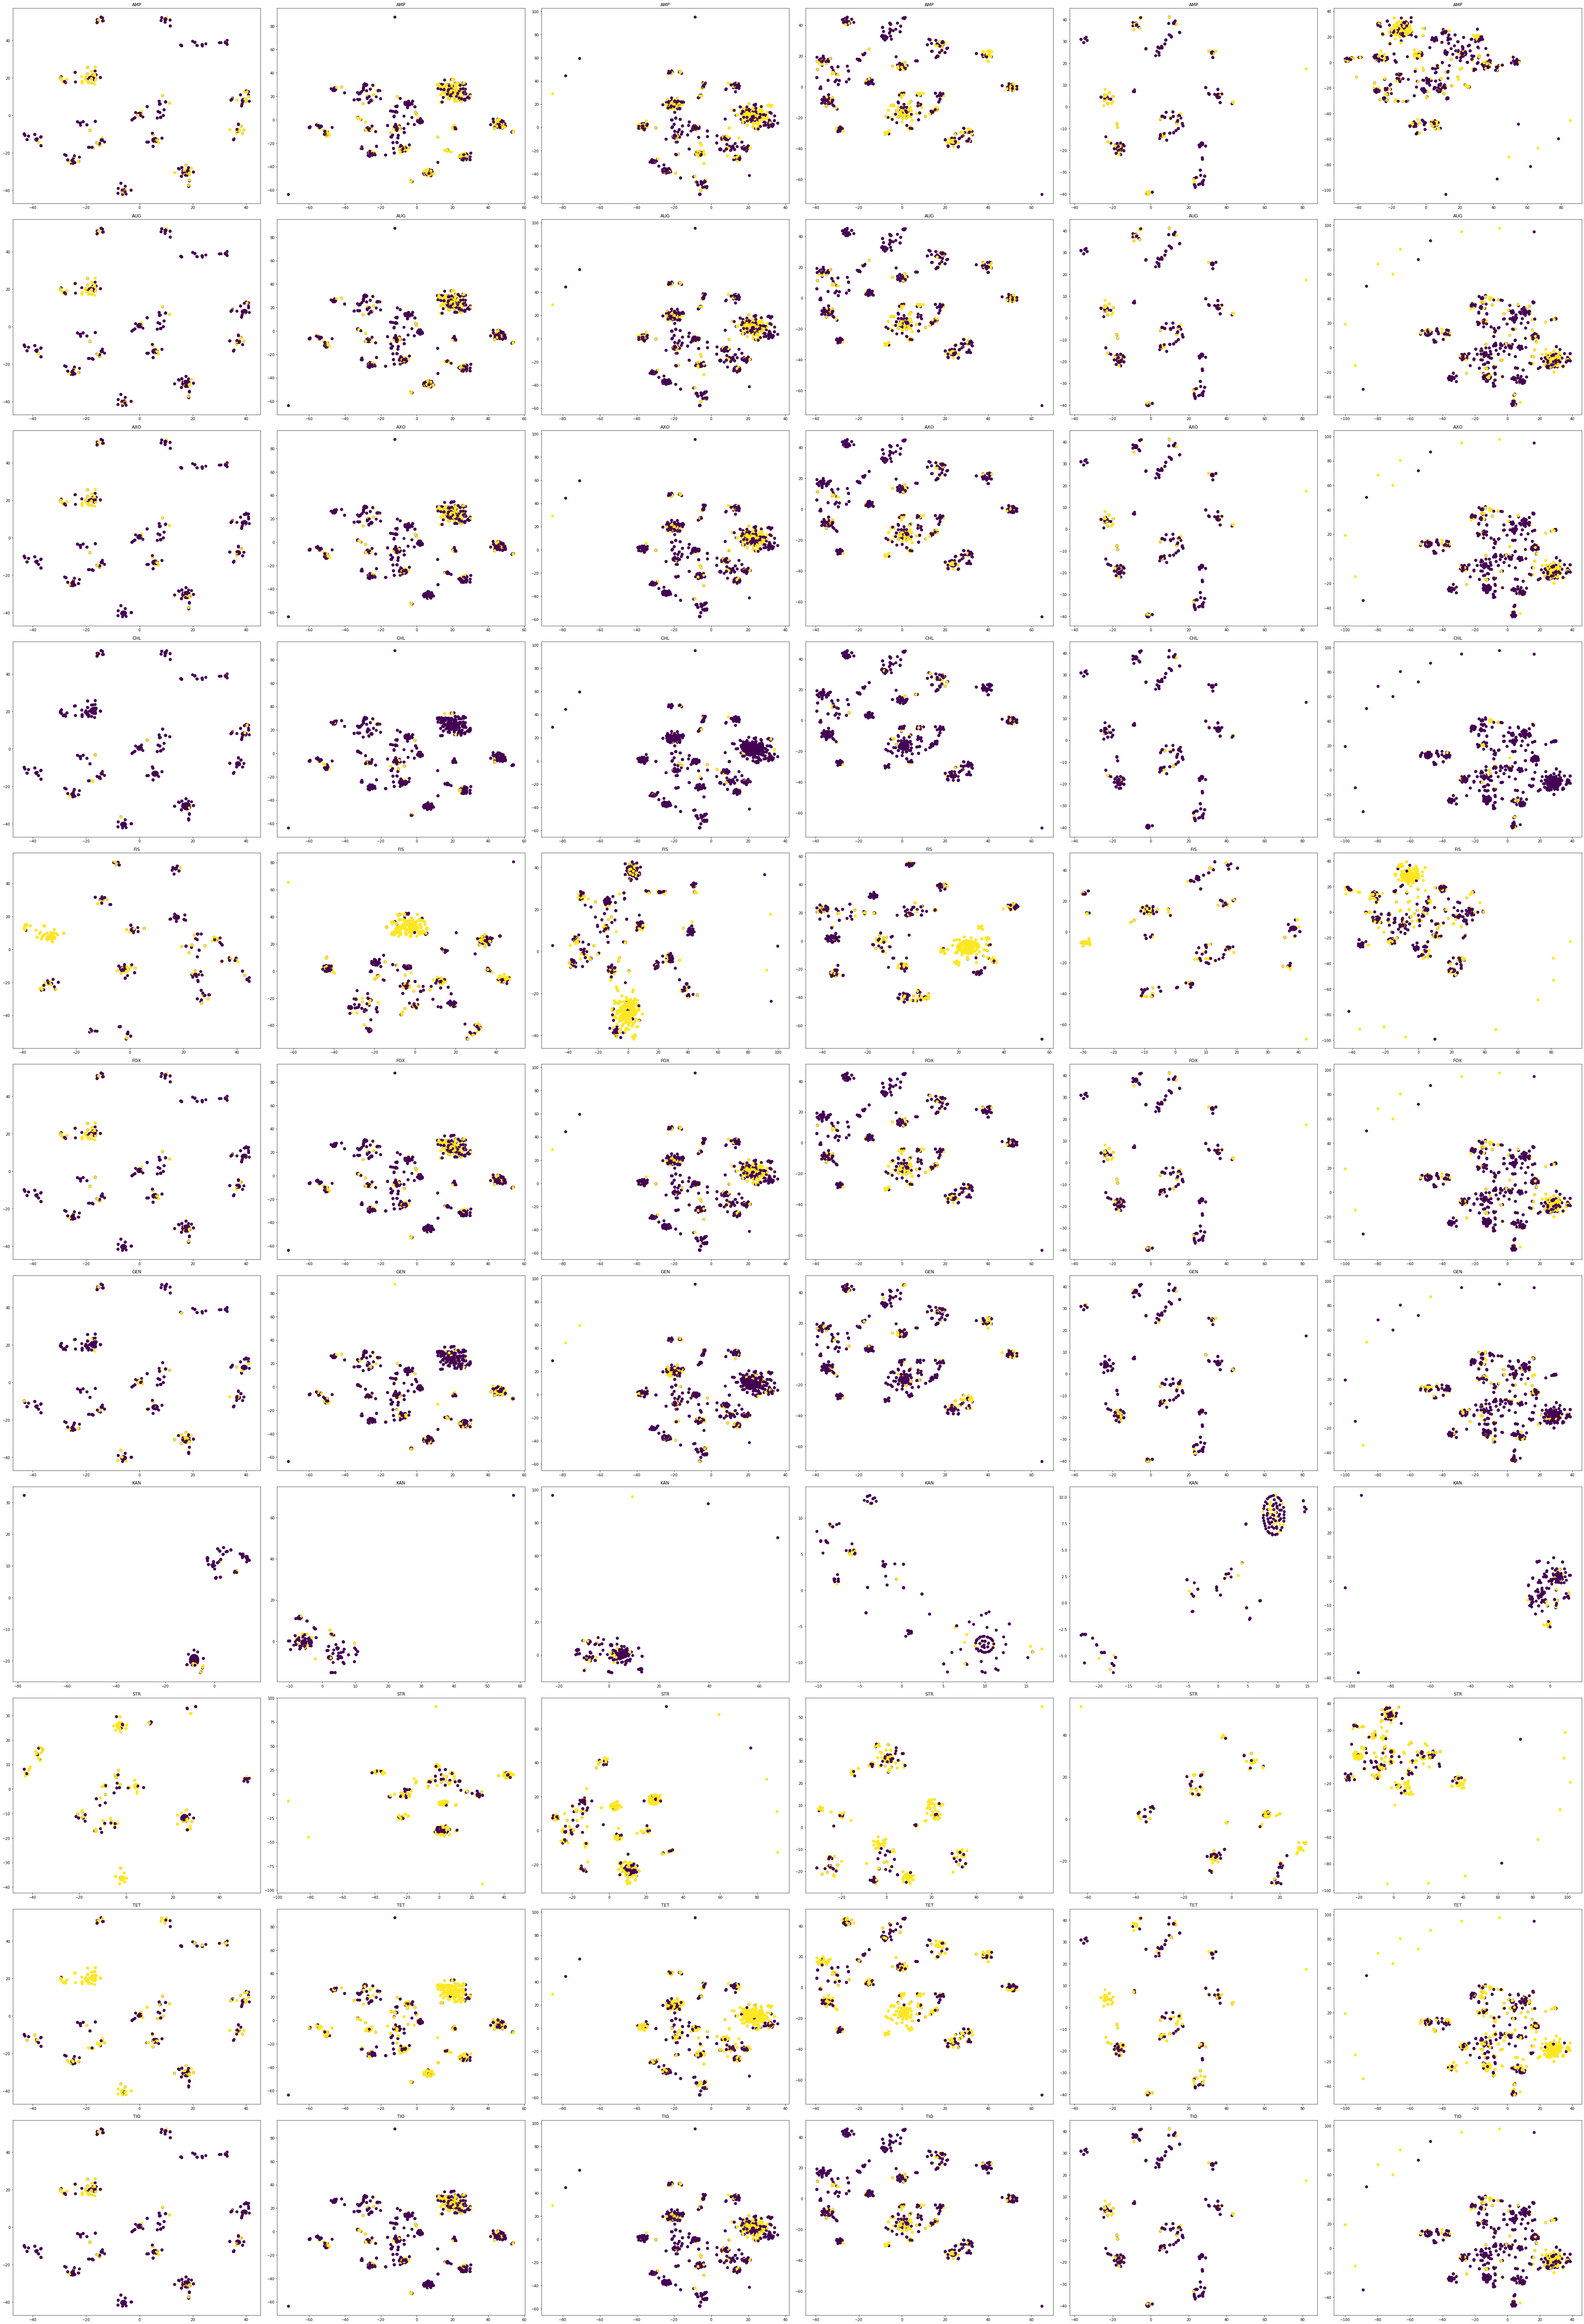

In [135]:
figure, axis = plt.subplots(nrows=len(antibiotics), ncols=6, figsize=(10*6, 8*len(antibiotics)))  # Adjusting the size to fit all plots

for row in range(len(antibiotics)):
    for col in range(5):
        data = dfs[antibiotics[row]][[antibiotics[row]] + globals()[f'length_{col}']]
        features = data.drop(columns=[antibiotics[row]])
        labels = data[antibiotics[row]]
        
        # Apply t-SNE with two dimensions
        tsne = TSNE(n_components=2, random_state=10)
        tsne_results = tsne.fit_transform(features)
        
        df_tsne = pd.DataFrame()  
        df_tsne['t-SNE1'] = tsne_results[:,0]
        df_tsne['t-SNE2'] = tsne_results[:,1]

        # 2D Plot for t-SNE results
        ax = axis[row, col]  # Use the current axis
        scatter = ax.scatter(df_tsne['t-SNE1'], df_tsne['t-SNE2'], c=labels, cmap='viridis', s=50)
        ax.set_title(antibiotics[row])
        
    data = dfs[antibiotics[row]]
    features = data.drop(columns=[antibiotics[row]])
    labels = data[antibiotics[row]]

    # Apply t-SNE with two dimensions
    tsne = TSNE(n_components=2, random_state=10)
    tsne_results = tsne.fit_transform(features)

    df_tsne = pd.DataFrame()  
    df_tsne['t-SNE1'] = tsne_results[:,0]
    df_tsne['t-SNE2'] = tsne_results[:,1]

    # 2D Plot for t-SNE results
    ax = axis[row, 5]  # Use the current axis
    scatter = ax.scatter(df_tsne['t-SNE1'], df_tsne['t-SNE2'], c=labels, cmap='viridis', s=50)
    ax.set_title(antibiotics[row])


plt.tight_layout() 
plt.show()

In [128]:
col=0

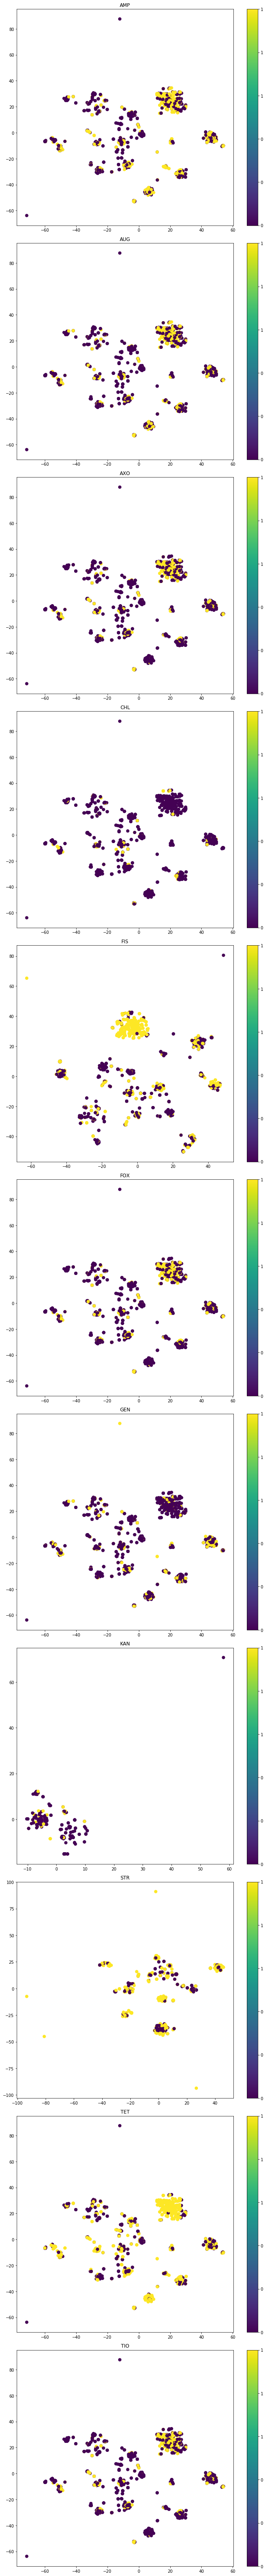

In [129]:
figure, axis = plt.subplots(nrows=len(antibiotics), ncols=1, figsize=(10, 8*len(antibiotics)))  # Adjusting the size to fit all plots

for row in range(len(antibiotics)):
    data = dfs[antibiotics[row]][[antibiotics[row]] + globals()[f'length_{col + 1}']]
    features = data.drop(columns=[antibiotics[row]])
    labels = data[antibiotics[row]]

    # Apply t-SNE with two dimensions
    tsne = TSNE(n_components=2, random_state=10)
    tsne_results = tsne.fit_transform(features)

    df_tsne = pd.DataFrame()  
    df_tsne['t-SNE1'] = tsne_results[:,0]
    df_tsne['t-SNE2'] = tsne_results[:,1]

    # 2D Plot for t-SNE results
    ax = axis[row]  # Use the current axis
    scatter = ax.scatter(df_tsne['t-SNE1'], df_tsne['t-SNE2'], c=labels, cmap='viridis', s=50)
    ax.set_title(antibiotics[row])

    # Optionally, you can add a colorbar for clarity
    cbar = figure.colorbar(scatter, ax=ax, format='%1.0f')

plt.tight_layout()
plt.show()

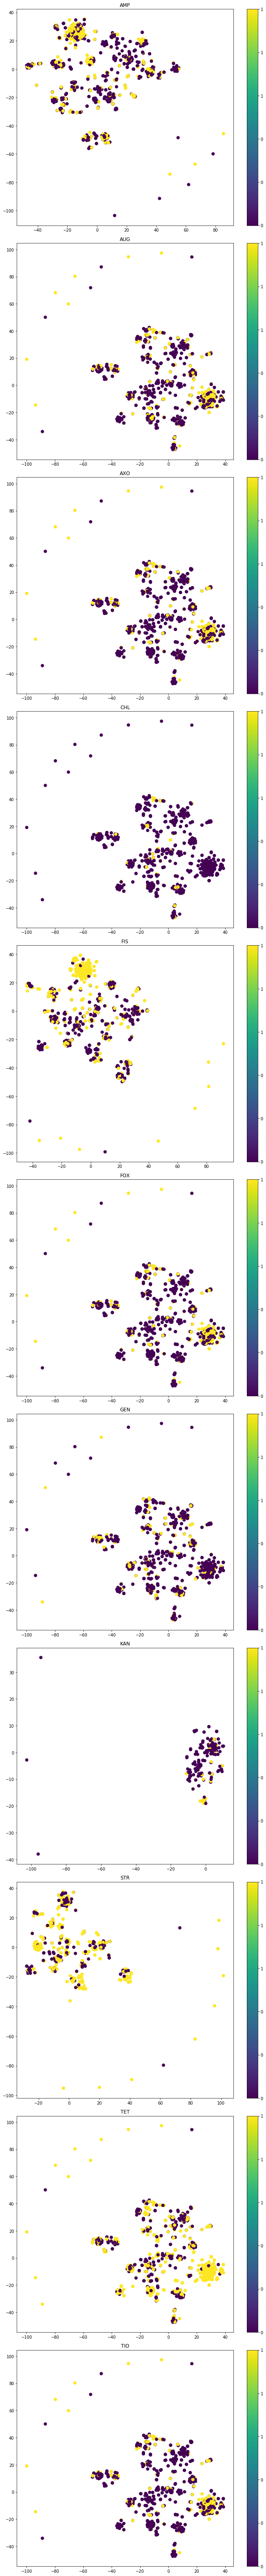

In [130]:
figure, axis = plt.subplots(nrows=len(antibiotics), ncols=1, figsize=(10, 8*len(antibiotics)))  # Adjusting the size to fit all plots

for row in range(len(antibiotics)):
    data = dfs[antibiotics[row]]
    features = data.drop(columns=[antibiotics[row]])
    labels = data[antibiotics[row]]

    # Apply t-SNE with two dimensions
    tsne = TSNE(n_components=2, random_state=10)
    tsne_results = tsne.fit_transform(features)

    df_tsne = pd.DataFrame()  
    df_tsne['t-SNE1'] = tsne_results[:,0]
    df_tsne['t-SNE2'] = tsne_results[:,1]

    # 2D Plot for t-SNE results
    ax = axis[row]  # Use the current axis
    scatter = ax.scatter(df_tsne['t-SNE1'], df_tsne['t-SNE2'], c=labels, cmap='viridis', s=50)
    ax.set_title(antibiotics[row])

    # Optionally, you can add a colorbar for clarity
    cbar = figure.colorbar(scatter, ax=ax, format='%1.0f')

plt.tight_layout()
plt.show()